In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
import joblib
import scipy


In [2]:
df_train=pd.read_csv("data/train.csv")
df_train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [4]:
df_test=pd.read_csv("data/test.csv")
df_test.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      172585 non-null  int64  
 1   road_type               172585 non-null  object 
 2   num_lanes               172585 non-null  int64  
 3   curvature               172585 non-null  float64
 4   speed_limit             172585 non-null  int64  
 5   lighting                172585 non-null  object 
 6   weather                 172585 non-null  object 
 7   road_signs_present      172585 non-null  bool   
 8   public_road             172585 non-null  bool   
 9   time_of_day             172585 non-null  object 
 10  holiday                 172585 non-null  bool   
 11  school_season           172585 non-null  bool   
 12  num_reported_accidents  172585 non-null  int64  
dtypes: bool(4), float64(1), int64(4), object(4)
memory usage: 12.5+ MB


In [6]:
df_test["accident_risk"]= 0
combined = pd.concat([df_train,df_test], axis=0, ignore_index=True)

combined=combined.drop("id", axis=1)
FEATURES = combined.columns[:-1]
TARGET = combined.columns[-1:]


In [7]:
"""
This code builds a weighted risk score and then smoothly clips 
it into a clean 0–1 target using a truncated normal, 
which I’ll use to compute residuals for training.
"""

def f(X):
    return \
    0.3 * X["curvature"] + \
    0.2 * (X["lighting"] == "night").astype(int) + \
    0.1 * (X["weather"] != "clear").astype(int) + \
    0.2 * (X["speed_limit"] >= 60).astype(int) + \
    0.1 * (X["num_reported_accidents"] > 2).astype(int)

def clip(f):
    def clip_f(X):
        sigma = 0.05
        mu = f(X)
        a, b = -mu/sigma, (1-mu)/sigma
        Phi_a, Phi_b = scipy.stats.norm.cdf(a), scipy.stats.norm.cdf(b)
        phi_a, phi_b = scipy.stats.norm.pdf(a), scipy.stats.norm.pdf(b)
        return mu*(Phi_b-Phi_a)+sigma*(phi_a-phi_b)+1-Phi_b
    return clip_f

z = clip(f)(combined)
combined["y"] = z.values

In [8]:
combined.head() 

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,y
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13,0.118153
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35,0.297000
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30,0.389000
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21,0.121128
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56,0.474000


In [9]:
""" 
identififying numerical columns and categorical columns 
and the number of unique values in the have 
"""
CATS = []
NUMS = []
for c in FEATURES:
    t = "CAT"
    if combined[c].dtype=='object':
        CATS.append(c)
    else:
        NUMS.append(c)
        t = "NUM"
    n = combined[c].nunique()
    na = combined[c].isna().sum()
    print(f"[{t}] {c} has {n} unique and {na} NA")
print("CATS:", CATS )
print("NUMS:", NUMS )

[CAT] road_type has 3 unique and 0 NA
[NUM] num_lanes has 4 unique and 0 NA
[NUM] curvature has 298 unique and 0 NA
[NUM] speed_limit has 5 unique and 0 NA
[CAT] lighting has 3 unique and 0 NA
[CAT] weather has 3 unique and 0 NA
[NUM] road_signs_present has 2 unique and 0 NA
[NUM] public_road has 2 unique and 0 NA
[CAT] time_of_day has 3 unique and 0 NA
[NUM] holiday has 2 unique and 0 NA
[NUM] school_season has 2 unique and 0 NA
[NUM] num_reported_accidents has 8 unique and 0 NA
CATS: ['road_type', 'lighting', 'weather', 'time_of_day']
NUMS: ['num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'num_reported_accidents']


## features Engineering 

In [10]:
# Developing feature that can give insightfull information for prediction 

combined["is_low_visibility"] = combined["lighting"].isin(["night", "dim"]).astype("int32")
combined["bad_weather"] = combined["weather"].isin(["rainy", "foggy"]).astype("int32")
combined["rush_hour"] = combined["time_of_day"].isin(["morning","evening"]).astype("int32")
combined["sharp_curve"] = (combined["curvature"]>0.6).astype("int32")
combined["high_speed"] = (combined["speed_limit"]>60).astype("int32")
combined["speed_curvature"] = combined["speed_limit"] * combined["curvature"]
combined["speed_dark"] = combined["speed_limit"] * combined["is_low_visibility"]
combined ["curve_dark"] = ((combined["curvature"]>0.6) & combined["is_low_visibility"]==1).astype("int32")
combined["curvature_group"] = (combined["curvature"] * 5).astype("int32").clip(0,4)

# encoding categorical columns 
for c in CATS:
    combined[c],_ = combined[c].factorize()
    combined[c] = combined[c].astype('int32')
    combined[c] = combined[c].astype('int32')
for num in NUMS:
    combined[num]=combined[num].astype("int32") 
combined["accident_risk"] = combined["accident_risk"].astype("float32")

TARGET = "accident_risk"
FEATURES = [col for col in combined.columns if col not in [TARGET]]

TE_FEATURES = []
for c in combined.columns:
    n = combined[c].nunique()
    if n < 10:
        TE_FEATURES.append(c)
        

df_train = combined.iloc[:len(df_train)].copy()
df_test = combined.iloc[len(df_train):].drop(columns="accident_risk", axis=1).copy()


In [11]:
    
def smooth_target_encode(train, test, group_cols, target_col, alpha=10):
    
    """
    Creates smoothed target encoding for one or more grouping columns.
    Returns updated train/test DataFrames and the new feature name.
    """
    # Ensure group_cols is a list
    if isinstance(group_cols, str):
        group_cols = [group_cols]

    # New encoded column name
    new_col = "TE_" + "_".join(group_cols)

    # Global mean
    global_mean = train[target_col].mean()

    # Group stats
    group_stats = (
        train.groupby(group_cols)
        .agg(["mean", "count"])[target_col]
        .reset_index()
    )
    # renaming the columns 
    group_stats.columns=group_cols + ["mean","count"]
    
    # Compute smoothed mean
    group_stats[new_col] = (
        (group_stats["count"] * group_stats["mean"] + alpha * global_mean)
        / (group_stats["count"] + alpha)
    )
    
    # Keep group columns + new col
    group_stats = group_stats[group_cols + [new_col]]

    # Merge into train/test
    train = train.merge(group_stats, on=group_cols, how="left")
    test = test.merge(group_stats, on=group_cols, how="left")
    return train, test, new_col


TE_colum_combination=[["curvature_group","lighting"],["speed_limit","lighting"], ["curvature_group","speed_limit"]]    
TE = []
for group_cols in list(TE_FEATURES) + TE_colum_combination:
    df_train,df_test,new_col = smooth_target_encode(df_train, df_test, group_cols,"accident_risk", alpha=10)
    TE.append(new_col)    
        

In [12]:
df_train.columns

Index(['road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents', 'accident_risk',
       'y', 'is_low_visibility', 'bad_weather', 'rush_hour', 'sharp_curve',
       'high_speed', 'speed_curvature', 'speed_dark', 'curve_dark',
       'curvature_group', 'TE_road_type', 'TE_num_lanes', 'TE_curvature',
       'TE_speed_limit', 'TE_lighting', 'TE_weather', 'TE_road_signs_present',
       'TE_public_road', 'TE_time_of_day', 'TE_holiday', 'TE_school_season',
       'TE_num_reported_accidents', 'TE_is_low_visibility', 'TE_bad_weather',
       'TE_rush_hour', 'TE_sharp_curve', 'TE_high_speed', 'TE_speed_dark',
       'TE_curve_dark', 'TE_curvature_group', 'TE_curvature_group_lighting',
       'TE_speed_limit_lighting', 'TE_curvature_group_speed_limit'],
      dtype='object')

## Modeling using XGB 
The model will be train on the residual(which is the difference between the target and the weighted score, y that was calculated) and after predicting the residuls we will reconstruct our main target(accident_risk). y is calculated base on the information we have 

In [13]:
# Defining all our parameters 
FOLDS = 5
SEED = 42

params = {
    "objective": "reg:squarederror",   
    "eval_metric": "rmse",             
    "learning_rate": 0.01,
    "max_depth": 6,                    
    "subsample": 0.9,
    "colsample_bytree": 0.6,
    "seed": SEED,
    "device": "cpu"
}

In [14]:
oof_preds = np.zeros(len(df_train))
test_preds = np.zeros(len(df_test))

kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train)):
    print("#"*25)
    print(f"### Fold {fold+1} ###")
    print("#"*25)

    X_train = df_train.iloc[train_idx][FEATURES+TE].copy()
    y_train = df_train.iloc[train_idx][TARGET] - df_train.iloc[train_idx]['y']

    X_valid = df_train.iloc[val_idx][FEATURES+TE].copy()
    y_valid = df_train.iloc[val_idx][TARGET] - df_train.iloc[val_idx]['y']
    y_valid2 = df_train.iloc[val_idx]['y'].values

    X_test = df_test[FEATURES+TE].copy()
    y_test2 = df_test['y'].values

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dval   = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    dtest  = xgb.DMatrix(X_test, enable_categorical=True)

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=100_000,
        evals=[(dtrain, "train"), (dval, "valid")],
        early_stopping_rounds=200,
        verbose_eval=200 )


    oof_preds[val_idx] = model.predict(dval, iteration_range=(0, model.best_iteration + 1)) +y_valid2
    test_preds += (model.predict(dtest, iteration_range=(0, model.best_iteration + 1)) +y_test2)/ FOLDS
    print(model.best_iteration)
       

#########################
### Fold 1 ###
#########################
[0]	train-rmse:0.05846	valid-rmse:0.05871
[200]	train-rmse:0.05650	valid-rmse:0.05683
[400]	train-rmse:0.05624	valid-rmse:0.05665
[600]	train-rmse:0.05609	valid-rmse:0.05656
[800]	train-rmse:0.05597	valid-rmse:0.05649
[1000]	train-rmse:0.05586	valid-rmse:0.05643
[1200]	train-rmse:0.05577	valid-rmse:0.05639
[1400]	train-rmse:0.05568	valid-rmse:0.05636
[1600]	train-rmse:0.05561	valid-rmse:0.05633
[1800]	train-rmse:0.05554	valid-rmse:0.05632
[2000]	train-rmse:0.05547	valid-rmse:0.05630
[2200]	train-rmse:0.05541	valid-rmse:0.05629
[2400]	train-rmse:0.05535	valid-rmse:0.05628
[2600]	train-rmse:0.05529	valid-rmse:0.05627
[2800]	train-rmse:0.05524	valid-rmse:0.05626
[3000]	train-rmse:0.05518	valid-rmse:0.05626
[3200]	train-rmse:0.05513	valid-rmse:0.05625
[3400]	train-rmse:0.05509	valid-rmse:0.05625
[3600]	train-rmse:0.05504	valid-rmse:0.05625
[3800]	train-rmse:0.05499	valid-rmse:0.05625
[3820]	train-rmse:0.05499	valid-rmse:0.0

In [15]:
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(oof_preds, df_train[TARGET])

In [16]:
rmse

0.05606686034498099

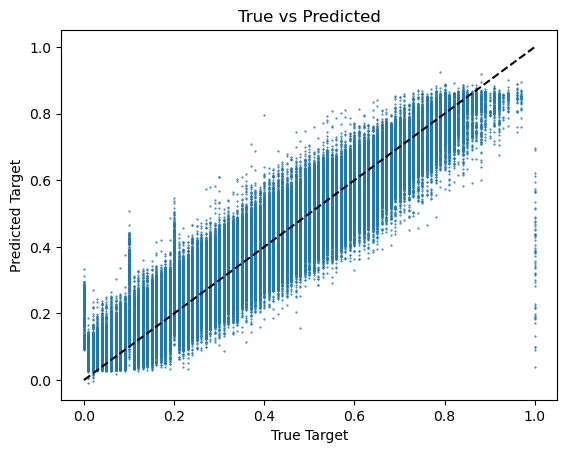

In [17]:
import matplotlib.pyplot as plt

plt.scatter(df_train[TARGET].values,oof_preds,s=0.25)
plt.plot([0,1],[0,1],'--',color='black')
plt.title("True vs Predicted")
plt.xlabel("True Target")
plt.ylabel("Predicted Target")
plt.show()

In [18]:
# sub = pd.read_csv("/kaggle/input/playground-series-s5e10/sample_submission.csv")
# sub['accident_risk'] = test_preds
# sub.to_csv("submission.csv",index=False)
# sub.head()

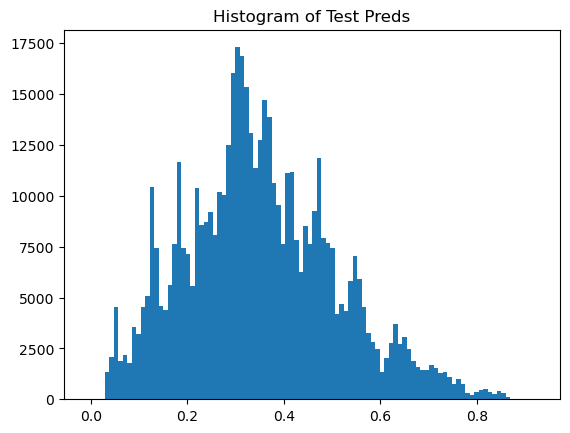

In [19]:
plt.hist(oof_preds,bins=100)
plt.title("Histogram of Test Preds")
plt.show()

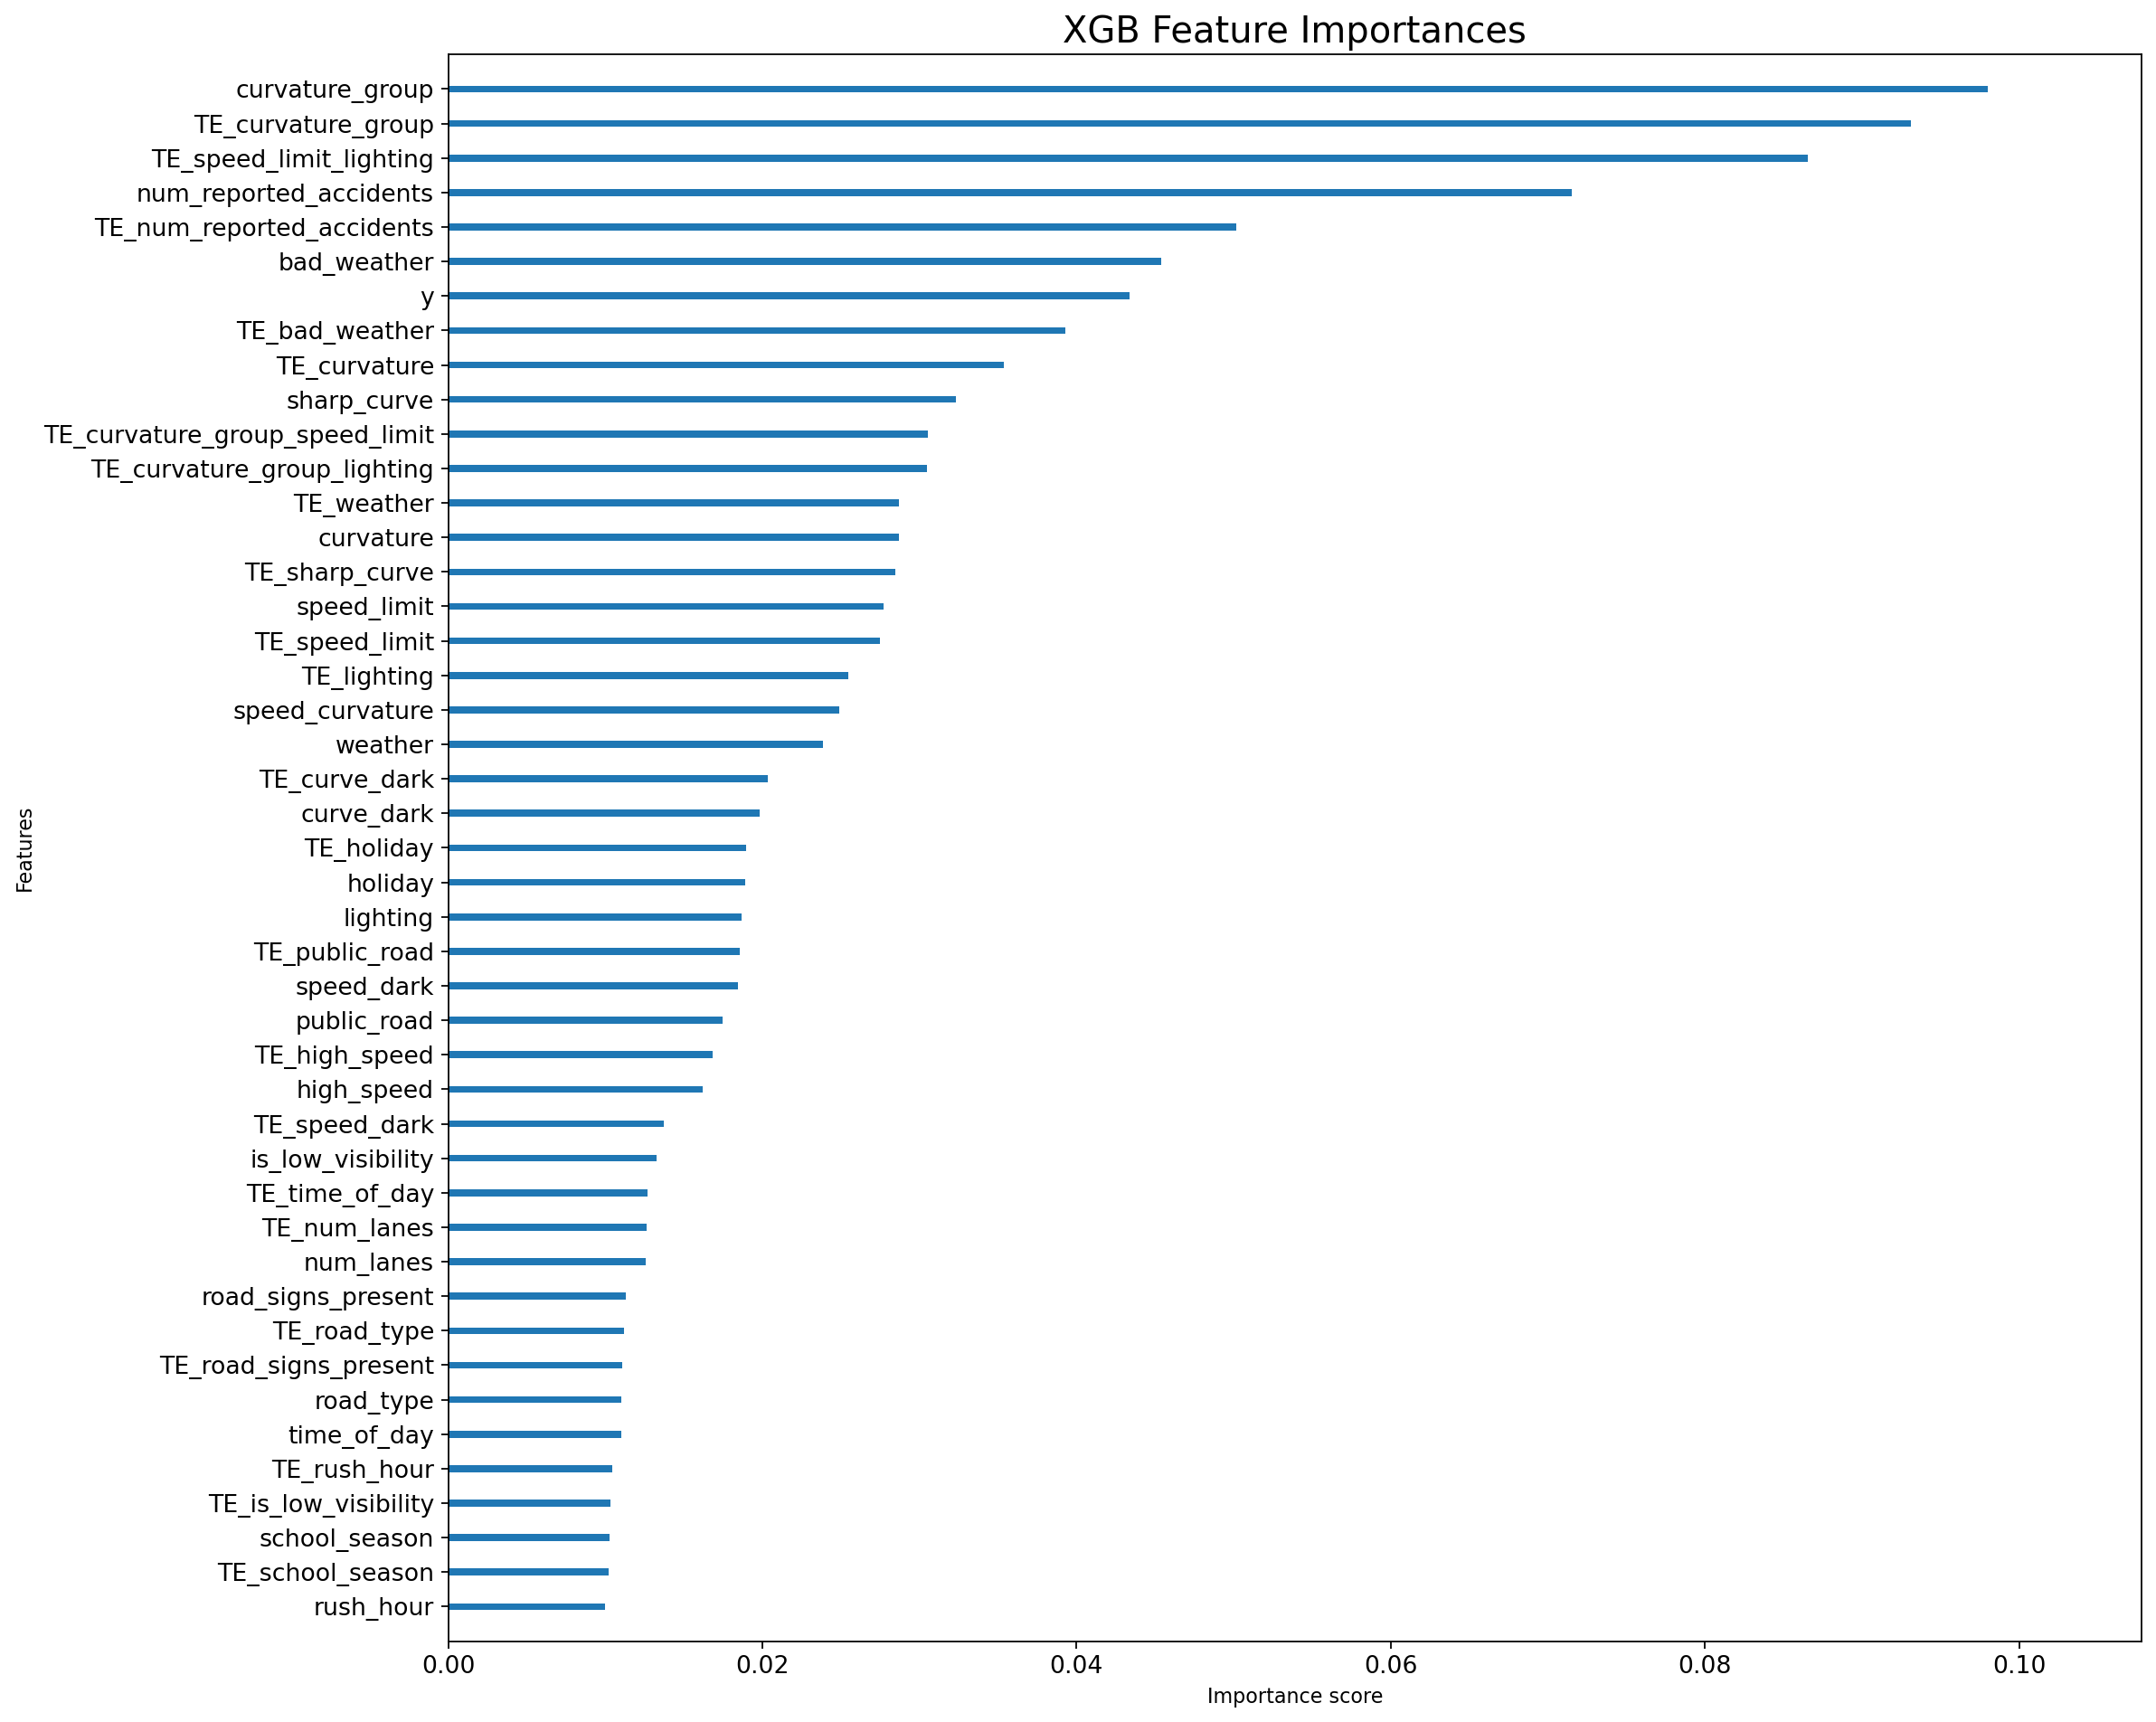

In [20]:

plt.rcParams["figure.dpi"] = 160      
fig, ax = plt.subplots(figsize=(15, 12))

xgb.plot_importance(
    model,
    max_num_features=100,
    importance_type="gain",
    ax=ax,
    show_values=False,                
    grid=False
)

ax.set_title("XGB Feature Importances", fontsize=18)
ax.tick_params(axis="both", labelsize=12)
fig.tight_layout()
plt.show()

 ## Generating a pipeline 

In [22]:
df_train=pd.read_csv("data/train.csv")
df_test=pd.read_csv("data/test.csv")
df_test["accident_risk"]= test_preds

combined  = pd.concat([df_train,df_test], axis=0, ignore_index=True)
combined = combined.drop(["id"], axis=1)

combined.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [23]:
def f(X):
    return \
    0.3 * X["curvature"] + \
    0.2 * (X["lighting"] == "night").astype(int) + \
    0.1 * (X["weather"] != "clear").astype(int) + \
    0.2 * (X["speed_limit"] >= 60).astype(int) + \
    0.1 * (X["num_reported_accidents"] > 2).astype(int)

def clip(f):
    def clip_f(X):
        sigma = 0.05
        mu = f(X)
        a, b = -mu/sigma, (1-mu)/sigma
        Phi_a, Phi_b = scipy.stats.norm.cdf(a), scipy.stats.norm.cdf(b)
        phi_a, phi_b = scipy.stats.norm.pdf(a), scipy.stats.norm.pdf(b)
        return mu*(Phi_b-Phi_a)+sigma*(phi_a-phi_b)+1-Phi_b
    return clip_f

z = clip(f)(combined)
combined["y_structured"] = z.values
combined['residual'] = combined['accident_risk'] - combined['y_structured']

# Train on residuals (or directly on target)
X_train = combined.drop(columns=["accident_risk", "residual"])
y_train = combined["residual"]

In [ ]:
#  compute residuals before training 
# df_train['y_structured'] = (
#     0.3 * df_train["curvature"] +
#     0.2 * (df_train["lighting"] == "night").astype(int) +
#     0.1 * (df_train["weather"] != "clear").astype(int) +
#     0.2 * (df_train["speed_limit"] >= 60).astype(int)
# )
# df_train['residual'] = df_train['accident_risk'] - df_train['y_structured']

# # Train on residuals (or directly on target)
# X_train = df_train.drop(columns=["accident_risk", "residual"])
# y_train = df_train["residual"]


In [24]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self,):
        self.mappings_ = {}
        
    def fit(self, X, y=None):
        X = X.copy()

        # Identify and store mappings for categorical columns
        for c in X.columns:
            if X[c].dtype == 'object':
                X[c], uniques = X[c].factorize()
                X[c] = X[c].astype("int32")
                self.mappings_[c] = dict(zip(uniques, range(len(uniques))))
            else:
                X[c] = X[c].astype("int32")

        return self

    def _generate_string_based_features(self, X):
        """These rely on categories BEFORE factorization."""
        X = X.copy()

        X["is_low_visibility"] = X["lighting"].isin(["night", "dim"]).astype("int32")
        X["bad_weather"] = X["weather"].isin(["rainy", "foggy"]).astype("int32")
        X["rush_hour"] = X["time_of_day"].isin(["morning", "evening"]).astype("int32")

        return X

    def _generate_numeric_features(self, X):
        """These rely on numerical columns AFTER factorization."""
        X = X.copy()

        X["sharp_curve"] = (X["curvature"] > 0.6).astype("int32")
        X["high_speed"] = (X["speed_limit"] > 60).astype("int32")
        X["speed_curvature"] = X["speed_limit"] * X["curvature"]
        X["speed_dark"] = X["speed_limit"] * X["is_low_visibility"]
        X["curve_dark"] = ((X["curvature"] > 0.6) & (X["is_low_visibility"] == 1)).astype("int32")
        X["curvature_group"] = (X["curvature"] * 5).astype("int32").clip(0, 4)

        return X

    def transform(self, X):
        X = X.copy()

        # 1️⃣ Generate string-based features FIRST
        X = self._generate_string_based_features(X)

        # 2️⃣ Apply factorization mappings
        for c, mapping in self.mappings_.items():
            X[c] = X[c].map(mapping).fillna(-1).astype("int32")

        # 3️⃣ Generate numeric-only features
        X = self._generate_numeric_features(X)

        # Convert bool → int32
        bool_cols = X.select_dtypes(include=["bool"]).columns
        for bc in bool_cols:
            X[bc] = X[bc].astype("int32")

        for col in list(X.columns):
            if X[col].dtype == "object":
                X[col] = pd.Categorical(X[col]).codes.astype("int32")
        return X


In [25]:
C

In [26]:
from sklearn.pipeline import Pipeline 
from xgboost import XGBRegressor

en = FeatureEngineering()
en.fit(X_train)

X_tmp = en.transform(X_train)
FEATURES = []
for c in X_tmp.columns:
    n = X_tmp[c].nunique()
    if n < 10:
        FEATURES.append(c)
        
colum_combination=[["curvature_group","lighting"],["speed_limit","lighting"], 
                   ["curvature_group","speed_limit"]]    
te_FEATURES = FEATURES + colum_combination


params["n_estimators"] = int(np.mean([3942,3976,3487,3933,4209]))  

pipeline = Pipeline([
    ("features", FeatureEngineering()),
    ("target_encoding", TargetEncoder(cols=te_FEATURES)),
    ("model", XGBRegressor(**params))])

In [27]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features', FeatureEngineering()),
                ('target_encoding',
                 TargetEncoder(cols=['road_type', 'num_lanes', 'speed_limit',
                                     'lighting', 'weather',
                                     'road_signs_present', 'public_road',
                                     'time_of_day', 'holiday', 'school_season',
                                     'num_reported_accidents',
                                     'is_low_visibility', 'bad_weather',
                                     'rush_hour', 'sharp_curve', 'high_speed',
                                     'speed_dark', 'curve_dark',
                                     'cu...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=3909, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [28]:
# Save pipeline
joblib.dump(pipeline, "model_pipeline.pkl")


['model_pipeline.pkl']

In [29]:
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn
import joblib
import scipy

# taking note of the version in other to include it in requirement.txt 

versions = {
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "xgboost": xgb.__version__,
    "scikit-learn": sklearn.__version__,
    "joblib": joblib.__version__,
    "scipy": scipy.__version__
}

In [36]:
versions

{'pandas': '2.2.3',
 'numpy': '2.1.3',
 'xgboost': '3.1.1',
 'scikit-learn': '1.6.1',
 'joblib': '1.4.2',
 'scipy': '1.15.3'}